In [1]:
%%capture
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import timeit

import delfi.distribution as dd
import delfi.inference as infer
import delfi.generator as dg

from delfi.simulator import GaussMixture
import delfi.summarystats as ds
from delfi.utils.viz import plot_pdf

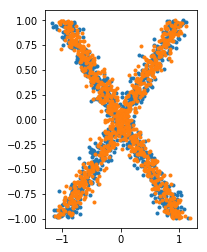

In [2]:
#p_true = dd.MoG(a=[0.5, 0.5], ms=[np.asarray([5., 5.]), np.asarray([-5., -5.])], Ss=[1.0*np.eye(2), 1.0*np.eye(2)])
#p_true.ndim=2

seed=42

return_abs = False

# basic approach to controlling generator seeds
def init_g(seed):
    m = GaussMixture(dim=2, bimodal=True, return_abs=return_abs, noise_cov=[0.01, 0.01], seed=seed)
    p = dd.Uniform(lower=[-1,-1], upper=[1,1], seed=seed)
    s = ds.Identity()
    return dg.Default(model=m, prior=p, summary=s)

g = init_g(seed=seed)

obs_stats = np.array([[.5, -.5]])

trn_data = g.gen(1000)
plt.subplot(1,2,1)
plt.plot(trn_data[1], trn_data[0], '.')
plt.show()

# SNPE parameters
    
n_components = 2
    
# training schedule
n_train=3000
n_rounds=5

# fitting setup
minibatch=100
epochs=50

# network setup
n_hiddens=[20,20]
reg_lambda=0.01

# convenience
pilot_samples=0
svi=False
verbose=True
prior_norm=False
init_norm=False


# MAF SNPE

In [8]:
from delfi.inference.SNPEC import snpec_maf_loss_discrete_proposal_null
from delfi.neuralnet.Trainer import Trainer, ActiveTrainer
import snl
from snl.ml.models.mafs import ConditionalMaskedAutoregressiveFlow

n_inputs  = 2 # dimensionality of summary stats
n_outputs = 2 # dimensionality of parameters
monitor_every = min(10 ** 5 // float(n_train), 1.0) # output
n_mades = 5 # number of MADES
act_fun = 'tanh'
rng = np.random
rng.seed(seed)

n_null = 2

model = ConditionalMaskedAutoregressiveFlow(
                n_inputs=n_inputs,
                n_outputs=n_outputs,
                n_hiddens=n_hiddens,
                act_fun=act_fun,
                n_mades=n_mades,
                mode='random',
                batch_norm=False,
                rng=rng)

model.aps = model.parms

loss, trn_inputs = snpec_maf_loss_discrete_proposal_null(maf=model, svi=False)

g = init_g(seed=seed)
trn_data = g.gen(n_train)

lprs = np.log(1.)-g.prior.eval(trn_data[0],log=True)
trn_data = (trn_data[0], trn_data[1], lprs)

t_ = timeit.time.time()

t = ActiveTrainer(model, 
                  loss,
                  trn_data=trn_data, 
                  trn_inputs=trn_inputs,
                  seed=None,
                  monitor=None)
print('compilation time', timeit.time.time() -  t_)

t_ = timeit.time.time()
log = t.train(
    proposal=g.prior,
    prior=g.prior,
    moo='p_tilda',
    obs=None,
    n_null=n_null,
    epochs=500, 
    minibatch=100, 
    stop_on_nan=True,
    verbose=False)

print(timeit.time.time() -  t_)




compilation time 16.218752145767212
91.14753675460815


/home/mackelab/Desktop/Projects/Biophysicality/code/snl_py3/snl/ml/models/mafs.py:231: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  output_order = output_order if output_order == 'random' else made.output_order[::-1]


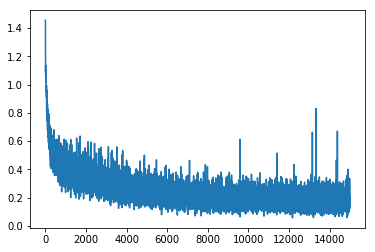

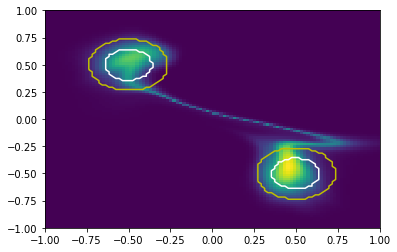

In [9]:
from delfi.utils.viz import probs2contours

plt.plot(log['loss'])
plt.show()

xo = 1.*obs_stats.flatten()
lims = np.array([[-1,1], [-1,1]])
i,j = 0,1
resolution = 100

p_true = dd.MoG(a=[0.5, 0.5], ms=[np.asarray([.5, -.5]), np.asarray([-.5, .5])], Ss=[0.01*np.eye(2), 0.01*np.eye(2)])
p_true.ndim=2

xx = np.linspace(lims[i, 0], lims[i, 1], resolution)
yy = np.linspace(lims[j, 0], lims[j, 1], resolution)
X, Y = np.meshgrid(xx, yy)
xy = np.concatenate(
    [X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)
pp = model.eval((xo, xy), log=False).reshape(list(X.shape))

plt.imshow(pp.T, origin='lower',
           extent=[lims[j, 0], lims[j, 1], lims[i, 0], lims[i, 1]],
           aspect='auto', interpolation='none')
pp = p_true.eval(xy, log=False).reshape(list(X.shape))
plt.contour(Y, X, probs2contours(pp, levels=(0.68, 0.95)), levels=(0.68, 0.95), colors=('w', 'y'))
#plt.savefig('/home/mackelab/Desktop/SNPC_1rounds_posterior_est.pdf')
plt.show()

# SNL

In [15]:
import sys
import snl.inference.nde as nde
import snl.ml.models.mafs as mafs
from delfi.utils.delfi2snl import SNLprior, SNLmodel

n_inputs  = 2 # dimensionality of summary stats
n_outputs = 2 # dimensionality of parameters
monitor_every = min(10 ** 5 // float(n_train), 1.0) # output
n_mades = 5 # number of MADES
act_fun = 'tanh'
rng = np.random
rng.seed(seed)

model = mafs.ConditionalMaskedAutoregressiveFlow(
                n_inputs=n_inputs,
                n_outputs=n_outputs,
                n_hiddens=n_hiddens,
                act_fun=act_fun,
                n_mades=n_mades,
                mode='random',
                rng=rng)

# generator
g = init_g(seed=seed)

# inference object
inf = nde.SequentialNeuralLikelihood(SNLprior(g.prior),               # method to draw parameters  
                                     SNLmodel(g.model, g.summary).gen # method to draw summary stats
                                    )

# train
t = timeit.time.time()

rng = np.random
rng.seed(seed)
model = inf.learn_likelihood(obs_stats.flatten(), model, n_samples=n_train, n_rounds=n_rounds, 
                             train_on_all=True, thin=10, save_models=False, 
                             logger=sys.stdout, rng=rng)

print(timeit.time.time() -  t)


Learning likelihood, round 1
simulating data... done
training model...
Epoch = 1.02, training loss = 2.3345739455508987, validation loss = 2.152857645590561
Epoch = 2.04, training loss = 1.965955401715267, validation loss = 1.8934603912999501
Epoch = 3.05, training loss = 1.7834652954776005, validation loss = 1.7476880301728974
Epoch = 4.07, training loss = 1.6250668737858385, validation loss = 1.6773680462048002
Epoch = 5.09, training loss = 1.7572636375451314, validation loss = 1.635488825284947
Epoch = 6.11, training loss = 1.7067829559209002, validation loss = 1.6015969011953062
Epoch = 7.12, training loss = 1.6223182712831703, validation loss = 1.5689726305658265
Epoch = 8.14, training loss = 1.6323056548879649, validation loss = 1.5372968932384612
Epoch = 9.16, training loss = 1.552998951660938, validation loss = 1.5088079144273283
Epoch = 10.18, training loss = 1.6232649760646611, validation loss = 1.4785792008265293
Epoch = 11.19, training loss = 1.566928960394913, validation l

Epoch = 95.65, training loss = 0.19688291783320203, validation loss = -0.10852772159771085
Epoch = 96.67, training loss = 0.18008628617976583, validation loss = -0.12727706056325813
Epoch = 97.68, training loss = 0.10104411924089911, validation loss = -0.12054383998151465
Epoch = 98.70, training loss = 0.210881569388101, validation loss = -0.1201918310727623
Epoch = 99.72, training loss = -0.04321626057849223, validation loss = -0.13714998559919836
Epoch = 100.74, training loss = 0.20802957031748343, validation loss = -0.14749608144324036
Epoch = 101.75, training loss = 0.17481230456545838, validation loss = -0.152099268883247
Epoch = 102.77, training loss = -0.054625860625222324, validation loss = -0.14236500565545593
Epoch = 103.79, training loss = 0.1750981289142444, validation loss = -0.15190050750180464
Epoch = 104.81, training loss = -0.023761929332323916, validation loss = -0.165844963302806
Epoch = 105.82, training loss = -0.08380776251786907, validation loss = -0.1703701012314

Epoch = 187.23, training loss = 0.004820697140758327, validation loss = -0.30944440627336556
Epoch = 188.25, training loss = -0.09357925237358523, validation loss = -0.32374655467973124
Epoch = 189.26, training loss = -0.17680725300416808, validation loss = -0.3229450765512152
Epoch = 190.28, training loss = -0.2873587256673785, validation loss = -0.32761711748712763
Epoch = 191.30, training loss = -0.09603806465213154, validation loss = -0.3300196029631731
Epoch = 192.32, training loss = -0.0860381645643616, validation loss = -0.33584350099532284
Epoch = 193.33, training loss = -0.2598225443249239, validation loss = -0.33900014089606706
Epoch = 194.35, training loss = -0.16767654264777612, validation loss = -0.33043471319511997
Epoch = 195.37, training loss = 0.11931679446537334, validation loss = -0.3332239123506612
Epoch = 196.39, training loss = -0.12121840187360919, validation loss = -0.34726645129173955
Epoch = 197.40, training loss = -0.2857166208448821, validation loss = -0.349

Epoch = 278.81, training loss = -0.3507742528055474, validation loss = -0.4668897470914437
Epoch = 279.82, training loss = -0.2764227172866041, validation loss = -0.4730708906754315
Epoch = 280.84, training loss = -0.47455561277923364, validation loss = -0.4677332539945569
Epoch = 281.86, training loss = -0.3069609180236868, validation loss = -0.46089259070677374
Epoch = 282.88, training loss = -0.29169558464697987, validation loss = -0.4696878125351435
Epoch = 283.89, training loss = -0.07954091820153764, validation loss = -0.4612491390511776
Epoch = 284.91, training loss = -0.403676714380339, validation loss = -0.479039539419258
Epoch = 285.93, training loss = -0.627181893836592, validation loss = -0.4744557471569928
Epoch = 286.95, training loss = -0.5004705529113798, validation loss = -0.47340294750206424
Epoch = 287.96, training loss = -0.4337129437605498, validation loss = -0.47281032833840053
Epoch = 288.98, training loss = -0.16195035864557006, validation loss = -0.476755943524

Epoch = 370.39, training loss = -0.5360811759365186, validation loss = -0.5253885652621266
Epoch = 371.40, training loss = -0.5044479966965534, validation loss = -0.5399023811724997
Epoch = 372.42, training loss = -0.13249175887331696, validation loss = -0.5393368764933085
Epoch = 373.44, training loss = -0.44090953916709347, validation loss = -0.5339258687228334
Epoch = 374.46, training loss = -0.3784664650623114, validation loss = -0.5358242568600885
Epoch = 375.47, training loss = -0.3745322210568278, validation loss = -0.524679719973659
Epoch = 376.49, training loss = -0.5294027602065985, validation loss = -0.5246709102178164
Epoch = 377.51, training loss = -0.361832591651252, validation loss = -0.5376548898419233
Epoch = 378.53, training loss = -0.2548218911077582, validation loss = -0.533416421230789
Epoch = 379.54, training loss = -0.09462148163775368, validation loss = -0.5217424129634911
Epoch = 380.56, training loss = -0.4613948191388795, validation loss = -0.5397348333183916

sample = 123, log prob = -0.18
sample = 124, log prob = -2.2
sample = 125, log prob = -0.18
sample = 126, log prob = -1.0
sample = 127, log prob = -2.6
sample = 128, log prob = -0.62
sample = 129, log prob = -1.9
sample = 130, log prob = -0.1
sample = 131, log prob = -0.38
sample = 132, log prob = -3.6
sample = 133, log prob = -1.4
sample = 134, log prob = -2.5
sample = 135, log prob = -1.4
sample = 136, log prob = -0.24
sample = 137, log prob = -0.26
sample = 138, log prob = -0.14
sample = 139, log prob = -0.24
sample = 140, log prob = -3.0
sample = 141, log prob = -2.5
sample = 142, log prob = -0.52
sample = 143, log prob = -0.5
sample = 144, log prob = -0.57
sample = 145, log prob = -1.3
sample = 146, log prob = -1.0
sample = 147, log prob = -1.0
sample = 148, log prob = -0.14
sample = 149, log prob = -0.23
sample = 150, log prob = -0.48
sample = 151, log prob = -2.1
sample = 152, log prob = -0.61
sample = 153, log prob = -0.51
sample = 154, log prob = -0.83
sample = 155, log prob =

sample = 391, log prob = -0.4
sample = 392, log prob = -1.1
sample = 393, log prob = -2.0
sample = 394, log prob = -1.1
sample = 395, log prob = -0.38
sample = 396, log prob = -0.53
sample = 397, log prob = -0.11
sample = 398, log prob = -0.32
sample = 399, log prob = -0.22
sample = 400, log prob = -0.41
sample = 401, log prob = -0.27
sample = 402, log prob = -0.46
sample = 403, log prob = -1.4
sample = 404, log prob = -2.6
sample = 405, log prob = -1.9
sample = 406, log prob = -1.0
sample = 407, log prob = -1.3
sample = 408, log prob = -2.5
sample = 409, log prob = -0.87
sample = 410, log prob = -0.084
sample = 411, log prob = -1.5
sample = 412, log prob = -0.24
sample = 413, log prob = -0.29
sample = 414, log prob = -0.17
sample = 415, log prob = -0.7
sample = 416, log prob = -0.71
sample = 417, log prob = -0.26
sample = 418, log prob = -0.55
sample = 419, log prob = -0.22
sample = 420, log prob = -0.34
sample = 421, log prob = -0.46
sample = 422, log prob = -0.44
sample = 423, log p

sample = 660, log prob = -2.9
sample = 661, log prob = -1.5
sample = 662, log prob = -0.79
sample = 663, log prob = -0.49
sample = 664, log prob = -1.1
sample = 665, log prob = -0.15
sample = 666, log prob = -1.2
sample = 667, log prob = -1.6
sample = 668, log prob = -1.1
sample = 669, log prob = -2.1
sample = 670, log prob = -1.2
sample = 671, log prob = -0.18
sample = 672, log prob = -1.2
sample = 673, log prob = -0.54
sample = 674, log prob = -0.99
sample = 675, log prob = -2.4
sample = 676, log prob = -0.18
sample = 677, log prob = -1.2
sample = 678, log prob = -0.66
sample = 679, log prob = -0.32
sample = 680, log prob = -0.19
sample = 681, log prob = -0.19
sample = 682, log prob = -1.5
sample = 683, log prob = -1.2
sample = 684, log prob = -0.21
sample = 685, log prob = -0.56
sample = 686, log prob = -0.29
sample = 687, log prob = -0.18
sample = 688, log prob = -2.7
sample = 689, log prob = -1.9
sample = 690, log prob = -0.76
sample = 691, log prob = -0.36
sample = 692, log prob 

sample = 930, log prob = -0.21
sample = 931, log prob = -1.6
sample = 932, log prob = -1.1
sample = 933, log prob = -0.19
sample = 934, log prob = -0.67
sample = 935, log prob = -0.63
sample = 936, log prob = -0.65
sample = 937, log prob = -0.28
sample = 938, log prob = -0.57
sample = 939, log prob = -0.75
sample = 940, log prob = -0.72
sample = 941, log prob = -0.85
sample = 942, log prob = -1.6
sample = 943, log prob = -1.4
sample = 944, log prob = -1.1
sample = 945, log prob = -0.29
sample = 946, log prob = -0.79
sample = 947, log prob = -2.5
sample = 948, log prob = -1.0
sample = 949, log prob = -1.6
sample = 950, log prob = -1.2
sample = 951, log prob = -1.4
sample = 952, log prob = -1.5
sample = 953, log prob = -0.4
sample = 954, log prob = -0.63
sample = 955, log prob = -0.065
sample = 956, log prob = -2.0
sample = 957, log prob = -1.2
sample = 958, log prob = -0.41
sample = 959, log prob = -0.92
sample = 960, log prob = -0.45
sample = 961, log prob = -1.5
sample = 962, log prob

sample = 1194, log prob = -0.99
sample = 1195, log prob = -1.6
sample = 1196, log prob = -3.1
sample = 1197, log prob = -0.62
sample = 1198, log prob = -1.1
sample = 1199, log prob = -1.5
sample = 1200, log prob = -0.64
sample = 1201, log prob = -0.47
sample = 1202, log prob = -0.49
sample = 1203, log prob = -0.83
sample = 1204, log prob = -0.63
sample = 1205, log prob = -1.9
sample = 1206, log prob = -0.11
sample = 1207, log prob = -0.41
sample = 1208, log prob = -0.47
sample = 1209, log prob = -0.65
sample = 1210, log prob = -0.17
sample = 1211, log prob = -0.48
sample = 1212, log prob = -1.8
sample = 1213, log prob = -3.6
sample = 1214, log prob = -0.27
sample = 1215, log prob = -0.44
sample = 1216, log prob = -0.054
sample = 1217, log prob = -3.4
sample = 1218, log prob = -1.7
sample = 1219, log prob = -1.8
sample = 1220, log prob = -0.34
sample = 1221, log prob = -0.21
sample = 1222, log prob = -0.43
sample = 1223, log prob = -0.92
sample = 1224, log prob = -0.55
sample = 1225, lo

sample = 1455, log prob = -2.8
sample = 1456, log prob = -0.28
sample = 1457, log prob = -0.58
sample = 1458, log prob = -1.7
sample = 1459, log prob = -0.37
sample = 1460, log prob = -0.27
sample = 1461, log prob = -0.24
sample = 1462, log prob = -0.37
sample = 1463, log prob = -1.3
sample = 1464, log prob = -0.36
sample = 1465, log prob = -0.8
sample = 1466, log prob = -0.21
sample = 1467, log prob = -1.2
sample = 1468, log prob = -1.2
sample = 1469, log prob = -2.0
sample = 1470, log prob = -0.77
sample = 1471, log prob = -0.53
sample = 1472, log prob = -0.44
sample = 1473, log prob = -1.7
sample = 1474, log prob = -0.99
sample = 1475, log prob = -1.0
sample = 1476, log prob = -1.1
sample = 1477, log prob = -2.9
sample = 1478, log prob = -2.1
sample = 1479, log prob = -0.3
sample = 1480, log prob = -1.0
sample = 1481, log prob = -0.46
sample = 1482, log prob = -0.47
sample = 1483, log prob = -0.65
sample = 1484, log prob = -0.79
sample = 1485, log prob = -0.94
sample = 1486, log pro

sample = 1716, log prob = -0.21
sample = 1717, log prob = -0.17
sample = 1718, log prob = -0.67
sample = 1719, log prob = -1.1
sample = 1720, log prob = -0.18
sample = 1721, log prob = -0.76
sample = 1722, log prob = -1.0
sample = 1723, log prob = -0.31
sample = 1724, log prob = -0.19
sample = 1725, log prob = -0.18
sample = 1726, log prob = -1.1
sample = 1727, log prob = -0.41
sample = 1728, log prob = -0.41
sample = 1729, log prob = -1.3
sample = 1730, log prob = -0.54
sample = 1731, log prob = -0.66
sample = 1732, log prob = -1.7
sample = 1733, log prob = -0.84
sample = 1734, log prob = -2.8
sample = 1735, log prob = -0.19
sample = 1736, log prob = -1.9
sample = 1737, log prob = -0.012
sample = 1738, log prob = -1.5
sample = 1739, log prob = -0.29
sample = 1740, log prob = -0.9
sample = 1741, log prob = -0.045
sample = 1742, log prob = -0.19
sample = 1743, log prob = -0.34
sample = 1744, log prob = -0.24
sample = 1745, log prob = -0.45
sample = 1746, log prob = -1.3
sample = 1747, l

sample = 1977, log prob = -0.69
sample = 1978, log prob = -2.6
sample = 1979, log prob = -1.1
sample = 1980, log prob = -0.38
sample = 1981, log prob = -1.0
sample = 1982, log prob = -0.45
sample = 1983, log prob = -0.31
sample = 1984, log prob = -0.41
sample = 1985, log prob = -0.62
sample = 1986, log prob = -0.21
sample = 1987, log prob = -0.43
sample = 1988, log prob = -0.72
sample = 1989, log prob = -0.26
sample = 1990, log prob = -0.78
sample = 1991, log prob = -0.34
sample = 1992, log prob = -0.28
sample = 1993, log prob = -0.8
sample = 1994, log prob = -0.33
sample = 1995, log prob = -0.48
sample = 1996, log prob = -3.6
sample = 1997, log prob = -0.74
sample = 1998, log prob = -0.68
sample = 1999, log prob = -0.15
sample = 2000, log prob = -2.1
sample = 2001, log prob = -0.35
sample = 2002, log prob = -1.2
sample = 2003, log prob = -0.39
sample = 2004, log prob = -0.38
sample = 2005, log prob = -1.7
sample = 2006, log prob = -0.61
sample = 2007, log prob = -0.42
sample = 2008, l

sample = 2238, log prob = -1.2
sample = 2239, log prob = -1.2
sample = 2240, log prob = -2.4
sample = 2241, log prob = -1.7
sample = 2242, log prob = -0.44
sample = 2243, log prob = -0.66
sample = 2244, log prob = -0.63
sample = 2245, log prob = -0.92
sample = 2246, log prob = -4.3
sample = 2247, log prob = -0.72
sample = 2248, log prob = -0.28
sample = 2249, log prob = -0.19
sample = 2250, log prob = -1.2
sample = 2251, log prob = -0.35
sample = 2252, log prob = -0.16
sample = 2253, log prob = -1.7
sample = 2254, log prob = -0.2
sample = 2255, log prob = -1.2
sample = 2256, log prob = -1.1
sample = 2257, log prob = -0.64
sample = 2258, log prob = -0.46
sample = 2259, log prob = -0.38
sample = 2260, log prob = -1.7
sample = 2261, log prob = -0.15
sample = 2262, log prob = -0.92
sample = 2263, log prob = -0.4
sample = 2264, log prob = -1.8
sample = 2265, log prob = -1.2
sample = 2266, log prob = -0.18
sample = 2267, log prob = -1.1
sample = 2268, log prob = -1.4
sample = 2269, log prob 

sample = 2499, log prob = -2.3
sample = 2500, log prob = -1.1
sample = 2501, log prob = -0.25
sample = 2502, log prob = -1.3
sample = 2503, log prob = -0.19
sample = 2504, log prob = -0.96
sample = 2505, log prob = -2.9
sample = 2506, log prob = -0.22
sample = 2507, log prob = -1.5
sample = 2508, log prob = -0.73
sample = 2509, log prob = -0.52
sample = 2510, log prob = -2.1
sample = 2511, log prob = -0.77
sample = 2512, log prob = -2.0
sample = 2513, log prob = -0.35
sample = 2514, log prob = -0.19
sample = 2515, log prob = -0.5
sample = 2516, log prob = -0.41
sample = 2517, log prob = -3.3
sample = 2518, log prob = -2.0
sample = 2519, log prob = -0.13
sample = 2520, log prob = -0.21
sample = 2521, log prob = -1.5
sample = 2522, log prob = -0.15
sample = 2523, log prob = -0.33
sample = 2524, log prob = -0.5
sample = 2525, log prob = -2.1
sample = 2526, log prob = -0.33
sample = 2527, log prob = -0.24
sample = 2528, log prob = -0.98
sample = 2529, log prob = -2.3
sample = 2530, log pro

sample = 2760, log prob = -0.22
sample = 2761, log prob = -0.38
sample = 2762, log prob = -0.18
sample = 2763, log prob = -0.49
sample = 2764, log prob = -0.76
sample = 2765, log prob = -1.4
sample = 2766, log prob = -0.63
sample = 2767, log prob = -0.89
sample = 2768, log prob = -1.4
sample = 2769, log prob = -0.19
sample = 2770, log prob = -1.4
sample = 2771, log prob = -0.24
sample = 2772, log prob = -3.5
sample = 2773, log prob = -1.3
sample = 2774, log prob = -1.7
sample = 2775, log prob = -0.28
sample = 2776, log prob = -2.5
sample = 2777, log prob = -1.5
sample = 2778, log prob = -1.6
sample = 2779, log prob = -0.76
sample = 2780, log prob = -0.72
sample = 2781, log prob = -0.59
sample = 2782, log prob = -0.36
sample = 2783, log prob = -0.58
sample = 2784, log prob = -0.39
sample = 2785, log prob = -0.46
sample = 2786, log prob = -1.9
sample = 2787, log prob = -0.81
sample = 2788, log prob = -4.1
sample = 2789, log prob = -1.5
sample = 2790, log prob = -1.4
sample = 2791, log pr

Epoch = 8.00, training loss = -0.11062443760545022, validation loss = -0.46355742478792666
Epoch = 9.00, training loss = -0.5980655018261061, validation loss = -0.4528958352233522
Epoch = 10.00, training loss = -0.3967580870836878, validation loss = -0.46592462217575
Epoch = 11.00, training loss = -0.4819898121058718, validation loss = -0.4742926444757509
Epoch = 12.00, training loss = -0.5539904475354791, validation loss = -0.47250655656853496
Epoch = 13.00, training loss = -0.20718505489472888, validation loss = -0.46194806336301764
Epoch = 14.00, training loss = -0.5117480121382371, validation loss = -0.4623982098209667
Epoch = 15.00, training loss = -0.648361681340433, validation loss = -0.47666862755545236
Epoch = 16.00, training loss = -0.4353251935117911, validation loss = -0.46665599963062077
Epoch = 17.00, training loss = -0.4040655453480083, validation loss = -0.475639503843218
Epoch = 18.00, training loss = -0.5300058582564754, validation loss = -0.47509130107989667
Epoch = 

sample = 20, log prob = -0.56
sample = 21, log prob = -2.3
sample = 22, log prob = -1.5
sample = 23, log prob = -0.83
sample = 24, log prob = 0.014
sample = 25, log prob = -3.0
sample = 26, log prob = -0.5
sample = 27, log prob = -1.1
sample = 28, log prob = -1.0
sample = 29, log prob = -0.077
sample = 30, log prob = -0.66
sample = 31, log prob = -0.074
sample = 32, log prob = -0.37
sample = 33, log prob = -1.5
sample = 34, log prob = -0.64
sample = 35, log prob = -0.33
sample = 36, log prob = -1.1
sample = 37, log prob = -0.073
sample = 38, log prob = -0.52
sample = 39, log prob = -1.4
sample = 40, log prob = -1.7
sample = 41, log prob = -0.035
sample = 42, log prob = -1.7
sample = 43, log prob = -0.35
sample = 44, log prob = -1.1
sample = 45, log prob = -0.19
sample = 46, log prob = -0.9
sample = 47, log prob = -0.071
sample = 48, log prob = -0.26
sample = 49, log prob = -0.91
sample = 50, log prob = -0.18
sample = 51, log prob = -1.0
sample = 52, log prob = -1.8
sample = 53, log pro

sample = 290, log prob = -0.58
sample = 291, log prob = -2.2
sample = 292, log prob = -0.86
sample = 293, log prob = -0.76
sample = 294, log prob = -1.5
sample = 295, log prob = -0.83
sample = 296, log prob = -0.5
sample = 297, log prob = -2.7
sample = 298, log prob = -0.3
sample = 299, log prob = -0.28
sample = 300, log prob = -0.37
sample = 301, log prob = -1.9
sample = 302, log prob = -0.34
sample = 303, log prob = -0.58
sample = 304, log prob = -0.57
sample = 305, log prob = -0.13
sample = 306, log prob = -1.1
sample = 307, log prob = -0.63
sample = 308, log prob = -0.33
sample = 309, log prob = -0.61
sample = 310, log prob = -0.37
sample = 311, log prob = -0.97
sample = 312, log prob = -1.4
sample = 313, log prob = -1.7
sample = 314, log prob = -4.7
sample = 315, log prob = -2.0
sample = 316, log prob = -0.34
sample = 317, log prob = -0.55
sample = 318, log prob = -0.15
sample = 319, log prob = 0.013
sample = 320, log prob = -0.86
sample = 321, log prob = -0.46
sample = 322, log p

sample = 560, log prob = -0.51
sample = 561, log prob = -0.33
sample = 562, log prob = -0.1
sample = 563, log prob = -0.78
sample = 564, log prob = -0.74
sample = 565, log prob = -0.56
sample = 566, log prob = -1.2
sample = 567, log prob = -0.66
sample = 568, log prob = -1.5
sample = 569, log prob = -2.1
sample = 570, log prob = -0.9
sample = 571, log prob = -0.055
sample = 572, log prob = -2.5
sample = 573, log prob = -0.066
sample = 574, log prob = -0.71
sample = 575, log prob = -0.2
sample = 576, log prob = -0.052
sample = 577, log prob = -2.1
sample = 578, log prob = -1.3
sample = 579, log prob = -0.52
sample = 580, log prob = -0.48
sample = 581, log prob = -2.3
sample = 582, log prob = 0.012
sample = 583, log prob = -0.076
sample = 584, log prob = -1.9
sample = 585, log prob = -0.028
sample = 586, log prob = -0.89
sample = 587, log prob = -3.4
sample = 588, log prob = -0.76
sample = 589, log prob = -0.17
sample = 590, log prob = -0.63
sample = 591, log prob = -2.8
sample = 592, lo

sample = 830, log prob = -1.2
sample = 831, log prob = -1.2
sample = 832, log prob = -1.2
sample = 833, log prob = -0.35
sample = 834, log prob = -2.7
sample = 835, log prob = -0.19
sample = 836, log prob = -0.17
sample = 837, log prob = -0.31
sample = 838, log prob = -0.62
sample = 839, log prob = -0.22
sample = 840, log prob = -0.46
sample = 841, log prob = -1.4
sample = 842, log prob = -0.24
sample = 843, log prob = -0.9
sample = 844, log prob = -0.53
sample = 845, log prob = -0.18
sample = 846, log prob = -1.1
sample = 847, log prob = -1.5
sample = 848, log prob = -0.081
sample = 849, log prob = -1.6
sample = 850, log prob = -0.061
sample = 851, log prob = -1.3
sample = 852, log prob = -1.6
sample = 853, log prob = -2.9
sample = 854, log prob = -3.5
sample = 855, log prob = -0.57
sample = 856, log prob = -0.33
sample = 857, log prob = -1.6
sample = 858, log prob = -0.24
sample = 859, log prob = -0.062
sample = 860, log prob = -1.2
sample = 861, log prob = -1.3
sample = 862, log pro

sample = 1097, log prob = -1.1
sample = 1098, log prob = -0.39
sample = 1099, log prob = -2.0
sample = 1100, log prob = -1.3
sample = 1101, log prob = -2.7
sample = 1102, log prob = -1.6
sample = 1103, log prob = -1.2
sample = 1104, log prob = -0.55
sample = 1105, log prob = -0.36
sample = 1106, log prob = -0.88
sample = 1107, log prob = -1.8
sample = 1108, log prob = -0.085
sample = 1109, log prob = -1.9
sample = 1110, log prob = -0.88
sample = 1111, log prob = -1.5
sample = 1112, log prob = -0.15
sample = 1113, log prob = -0.29
sample = 1114, log prob = -0.95
sample = 1115, log prob = -0.02
sample = 1116, log prob = -0.7
sample = 1117, log prob = -2.2
sample = 1118, log prob = -0.4
sample = 1119, log prob = 0.00031
sample = 1120, log prob = -1.2
sample = 1121, log prob = -0.5
sample = 1122, log prob = -1.0
sample = 1123, log prob = -1.3
sample = 1124, log prob = -1.5
sample = 1125, log prob = 0.055
sample = 1126, log prob = -0.13
sample = 1127, log prob = -1.3
sample = 1128, log prob

sample = 1356, log prob = -0.67
sample = 1357, log prob = -2.5
sample = 1358, log prob = -0.61
sample = 1359, log prob = -0.62
sample = 1360, log prob = -2.7
sample = 1361, log prob = -0.76
sample = 1362, log prob = -1.8
sample = 1363, log prob = -0.37
sample = 1364, log prob = -1.3
sample = 1365, log prob = -1.8
sample = 1366, log prob = -0.19
sample = 1367, log prob = -0.46
sample = 1368, log prob = -1.5
sample = 1369, log prob = -0.35
sample = 1370, log prob = -0.23
sample = 1371, log prob = -1.3
sample = 1372, log prob = -0.78
sample = 1373, log prob = -0.61
sample = 1374, log prob = -1.6
sample = 1375, log prob = -0.4
sample = 1376, log prob = -0.65
sample = 1377, log prob = -2.9
sample = 1378, log prob = -0.31
sample = 1379, log prob = -0.14
sample = 1380, log prob = -1.8
sample = 1381, log prob = -2.3
sample = 1382, log prob = -1.3
sample = 1383, log prob = -0.099
sample = 1384, log prob = -1.3
sample = 1385, log prob = -0.12
sample = 1386, log prob = -2.2
sample = 1387, log pro

sample = 1616, log prob = -0.12
sample = 1617, log prob = -1.4
sample = 1618, log prob = -0.44
sample = 1619, log prob = -2.7
sample = 1620, log prob = -1.0
sample = 1621, log prob = -0.8
sample = 1622, log prob = -1.7
sample = 1623, log prob = -0.82
sample = 1624, log prob = -1.2
sample = 1625, log prob = -3.6
sample = 1626, log prob = -0.71
sample = 1627, log prob = -0.39
sample = 1628, log prob = -1.0
sample = 1629, log prob = -4.2
sample = 1630, log prob = -0.079
sample = 1631, log prob = -2.1
sample = 1632, log prob = -1.9
sample = 1633, log prob = -1.2
sample = 1634, log prob = -0.48
sample = 1635, log prob = -0.58
sample = 1636, log prob = -1.9
sample = 1637, log prob = -2.8
sample = 1638, log prob = -0.73
sample = 1639, log prob = -0.39
sample = 1640, log prob = -1.2
sample = 1641, log prob = -0.27
sample = 1642, log prob = -0.32
sample = 1643, log prob = -0.26
sample = 1644, log prob = -0.28
sample = 1645, log prob = -0.65
sample = 1646, log prob = -0.7
sample = 1647, log prob

sample = 1877, log prob = -1.0
sample = 1878, log prob = -0.28
sample = 1879, log prob = -0.86
sample = 1880, log prob = -1.9
sample = 1881, log prob = -4.8
sample = 1882, log prob = -0.29
sample = 1883, log prob = -0.43
sample = 1884, log prob = -1.3
sample = 1885, log prob = -0.72
sample = 1886, log prob = -0.88
sample = 1887, log prob = -1.3
sample = 1888, log prob = -0.31
sample = 1889, log prob = -1.2
sample = 1890, log prob = -0.4
sample = 1891, log prob = -1.8
sample = 1892, log prob = -0.21
sample = 1893, log prob = -0.73
sample = 1894, log prob = -0.63
sample = 1895, log prob = -0.17
sample = 1896, log prob = -0.12
sample = 1897, log prob = -0.24
sample = 1898, log prob = -0.55
sample = 1899, log prob = -1.3
sample = 1900, log prob = -0.6
sample = 1901, log prob = -0.087
sample = 1902, log prob = -0.25
sample = 1903, log prob = -0.34
sample = 1904, log prob = -2.7
sample = 1905, log prob = -1.4
sample = 1906, log prob = -0.78
sample = 1907, log prob = -1.9
sample = 1908, log p

sample = 2138, log prob = -3.8
sample = 2139, log prob = -4.6
sample = 2140, log prob = -0.32
sample = 2141, log prob = -0.77
sample = 2142, log prob = -1.1
sample = 2143, log prob = -1.5
sample = 2144, log prob = -1.5
sample = 2145, log prob = -0.37
sample = 2146, log prob = -0.16
sample = 2147, log prob = -1.3
sample = 2148, log prob = -0.98
sample = 2149, log prob = -0.9
sample = 2150, log prob = -0.12
sample = 2151, log prob = -2.7
sample = 2152, log prob = -0.12
sample = 2153, log prob = -0.62
sample = 2154, log prob = -0.47
sample = 2155, log prob = -0.35
sample = 2156, log prob = -1.2
sample = 2157, log prob = -1.3
sample = 2158, log prob = -4.4
sample = 2159, log prob = -0.4
sample = 2160, log prob = -0.49
sample = 2161, log prob = -1.0
sample = 2162, log prob = -0.92
sample = 2163, log prob = -0.15
sample = 2164, log prob = -0.082
sample = 2165, log prob = -0.76
sample = 2166, log prob = -0.67
sample = 2167, log prob = -0.45
sample = 2168, log prob = -0.4
sample = 2169, log pr

sample = 2399, log prob = -0.2
sample = 2400, log prob = -0.26
sample = 2401, log prob = -0.6
sample = 2402, log prob = -0.98
sample = 2403, log prob = -1.3
sample = 2404, log prob = -0.09
sample = 2405, log prob = -0.19
sample = 2406, log prob = -2.1
sample = 2407, log prob = -0.49
sample = 2408, log prob = -4.1
sample = 2409, log prob = -1.8
sample = 2410, log prob = -4.2
sample = 2411, log prob = -1.3
sample = 2412, log prob = -4.0
sample = 2413, log prob = -2.0
sample = 2414, log prob = -0.3
sample = 2415, log prob = -0.31
sample = 2416, log prob = -0.9
sample = 2417, log prob = -0.23
sample = 2418, log prob = -1.0
sample = 2419, log prob = -0.1
sample = 2420, log prob = -2.5
sample = 2421, log prob = -1.4
sample = 2422, log prob = -0.34
sample = 2423, log prob = -1.1
sample = 2424, log prob = -0.66
sample = 2425, log prob = -0.097
sample = 2426, log prob = -0.47
sample = 2427, log prob = -1.4
sample = 2428, log prob = -0.2
sample = 2429, log prob = -0.38
sample = 2430, log prob = 

sample = 2657, log prob = -0.97
sample = 2658, log prob = -0.6
sample = 2659, log prob = -1.1
sample = 2660, log prob = -0.27
sample = 2661, log prob = -0.64
sample = 2662, log prob = -2.2
sample = 2663, log prob = -2.5
sample = 2664, log prob = -2.1
sample = 2665, log prob = -0.92
sample = 2666, log prob = -0.15
sample = 2667, log prob = -0.4
sample = 2668, log prob = -0.38
sample = 2669, log prob = -0.85
sample = 2670, log prob = -1.8
sample = 2671, log prob = -0.65
sample = 2672, log prob = -0.3
sample = 2673, log prob = -0.55
sample = 2674, log prob = -0.19
sample = 2675, log prob = -0.22
sample = 2676, log prob = -3.2
sample = 2677, log prob = -0.23
sample = 2678, log prob = -0.45
sample = 2679, log prob = -0.46
sample = 2680, log prob = -1.9
sample = 2681, log prob = -1.4
sample = 2682, log prob = -2.0
sample = 2683, log prob = -0.18
sample = 2684, log prob = -0.67
sample = 2685, log prob = -0.25
sample = 2686, log prob = -0.45
sample = 2687, log prob = -1.3
sample = 2688, log pr

sample = 2918, log prob = -0.063
sample = 2919, log prob = -0.27
sample = 2920, log prob = -0.71
sample = 2921, log prob = -1.4
sample = 2922, log prob = -0.14
sample = 2923, log prob = -0.31
sample = 2924, log prob = -0.31
sample = 2925, log prob = -1.5
sample = 2926, log prob = -1.5
sample = 2927, log prob = -0.23
sample = 2928, log prob = -0.37
sample = 2929, log prob = -0.34
sample = 2930, log prob = -1.3
sample = 2931, log prob = -1.5
sample = 2932, log prob = -2.3
sample = 2933, log prob = -0.45
sample = 2934, log prob = -0.44
sample = 2935, log prob = -1.4
sample = 2936, log prob = -0.27
sample = 2937, log prob = -0.21
sample = 2938, log prob = -1.9
sample = 2939, log prob = -1.5
sample = 2940, log prob = -0.33
sample = 2941, log prob = -0.61
sample = 2942, log prob = -0.088
sample = 2943, log prob = -1.1
sample = 2944, log prob = -0.26
sample = 2945, log prob = -1.3
sample = 2946, log prob = -0.32
sample = 2947, log prob = -2.2
sample = 2948, log prob = -1.1
sample = 2949, log 

Epoch = 64.37, training loss = -0.7166563898145146, validation loss = -0.7556056445227024
Epoch = 65.38, training loss = -0.6833719973242188, validation loss = -0.7375456991859266
Epoch = 66.39, training loss = -0.7462018945378139, validation loss = -0.7313164667452232
Epoch = 67.39, training loss = -0.6029830942402556, validation loss = -0.7361028304699118
Epoch = 68.40, training loss = -0.40532110514084685, validation loss = -0.7388698925860124
Epoch = 69.40, training loss = -0.757161392950052, validation loss = -0.7593172709860154
Epoch = 70.41, training loss = -0.4866188994915743, validation loss = -0.753379016114771
Epoch = 71.42, training loss = -0.7139991199551001, validation loss = -0.7465296305919248
Epoch = 72.42, training loss = -0.4378758226335022, validation loss = -0.7493234992498903
Epoch = 73.43, training loss = -0.7247335669652932, validation loss = -0.7496116942737506
Epoch = 74.43, training loss = -0.6960329513078949, validation loss = -0.7627709179991244
Epoch = 75.

Epoch = 156.91, training loss = -0.6564125488629814, validation loss = -0.8001401966101545
Epoch = 157.92, training loss = -0.8001621319549815, validation loss = -0.7945112669568394
Epoch = 158.92, training loss = -0.7213902640220514, validation loss = -0.7790492586129402
Epoch = 159.93, training loss = -0.7815645814353427, validation loss = -0.788515482230951
Epoch = 160.94, training loss = -0.8331909424649067, validation loss = -0.7929864152653856
Epoch = 161.94, training loss = -0.7430291099563711, validation loss = -0.7997873516486917
Epoch = 162.95, training loss = -0.6893416521641638, validation loss = -0.8001367687749353
Epoch = 163.95, training loss = -0.4182440828342036, validation loss = -0.7904589325077716
Epoch = 164.96, training loss = -0.6323228594290249, validation loss = -0.7775253617553456
Epoch = 165.96, training loss = -0.5348530532704356, validation loss = -0.792684372927512
Epoch = 166.97, training loss = -0.6993330928020011, validation loss = -0.789900173669144
Ep

sample = 39, log prob = -0.1
sample = 40, log prob = -0.72
sample = 41, log prob = -1.6
sample = 42, log prob = 0.14
sample = 43, log prob = -1.4
sample = 44, log prob = -1.5
sample = 45, log prob = -0.37
sample = 46, log prob = -1.8
sample = 47, log prob = -1.0
sample = 48, log prob = 0.24
sample = 49, log prob = 0.28
sample = 50, log prob = -0.25
sample = 51, log prob = -0.49
sample = 52, log prob = -1.0
sample = 53, log prob = -0.71
sample = 54, log prob = -0.86
sample = 55, log prob = 0.28
sample = 56, log prob = -0.17
sample = 57, log prob = -1.6
sample = 58, log prob = -0.78
sample = 59, log prob = -0.48
sample = 60, log prob = 0.35
sample = 61, log prob = 0.31
sample = 62, log prob = -0.52
sample = 63, log prob = 0.17
sample = 64, log prob = -2.8
sample = 65, log prob = -0.42
sample = 66, log prob = -0.32
sample = 67, log prob = 0.066
sample = 68, log prob = -1.5
sample = 69, log prob = -0.2
sample = 70, log prob = -0.4
sample = 71, log prob = -1.0
sample = 72, log prob = -0.087

sample = 312, log prob = -0.3
sample = 313, log prob = -1.5
sample = 314, log prob = -0.3
sample = 315, log prob = -0.52
sample = 316, log prob = -1.3
sample = 317, log prob = -0.85
sample = 318, log prob = 0.058
sample = 319, log prob = -1.1
sample = 320, log prob = -0.28
sample = 321, log prob = -0.096
sample = 322, log prob = -0.12
sample = 323, log prob = -1.5
sample = 324, log prob = -0.25
sample = 325, log prob = -0.61
sample = 326, log prob = -0.024
sample = 327, log prob = 0.22
sample = 328, log prob = -2.1
sample = 329, log prob = -0.39
sample = 330, log prob = -0.61
sample = 331, log prob = 0.22
sample = 332, log prob = -0.85
sample = 333, log prob = -0.5
sample = 334, log prob = 0.13
sample = 335, log prob = 0.34
sample = 336, log prob = 0.34
sample = 337, log prob = -0.084
sample = 338, log prob = -2.3
sample = 339, log prob = 0.18
sample = 340, log prob = 0.0092
sample = 341, log prob = -0.18
sample = 342, log prob = 0.048
sample = 343, log prob = -5.5
sample = 344, log pr

sample = 582, log prob = -0.97
sample = 583, log prob = 0.14
sample = 584, log prob = -2.2
sample = 585, log prob = -0.025
sample = 586, log prob = -0.53
sample = 587, log prob = -0.23
sample = 588, log prob = 0.22
sample = 589, log prob = -1.8
sample = 590, log prob = -0.2
sample = 591, log prob = -1.5
sample = 592, log prob = -0.24
sample = 593, log prob = 0.096
sample = 594, log prob = 0.17
sample = 595, log prob = 0.12
sample = 596, log prob = -1.2
sample = 597, log prob = -0.94
sample = 598, log prob = -0.7
sample = 599, log prob = -0.051
sample = 600, log prob = 0.25
sample = 601, log prob = 0.25
sample = 602, log prob = 0.3
sample = 603, log prob = -0.78
sample = 604, log prob = 0.14
sample = 605, log prob = 0.25
sample = 606, log prob = -0.29
sample = 607, log prob = -0.47
sample = 608, log prob = -1.7
sample = 609, log prob = 0.35
sample = 610, log prob = 0.22
sample = 611, log prob = 0.24
sample = 612, log prob = -0.043
sample = 613, log prob = 0.044
sample = 614, log prob = 

sample = 852, log prob = -0.68
sample = 853, log prob = 0.27
sample = 854, log prob = -0.22
sample = 855, log prob = -3.9
sample = 856, log prob = 0.1
sample = 857, log prob = -0.062
sample = 858, log prob = 0.35
sample = 859, log prob = -0.038
sample = 860, log prob = 0.36
sample = 861, log prob = 0.09
sample = 862, log prob = 0.021
sample = 863, log prob = -0.39
sample = 864, log prob = 0.35
sample = 865, log prob = 0.07
sample = 866, log prob = -0.41
sample = 867, log prob = -0.74
sample = 868, log prob = -1.2
sample = 869, log prob = -2.8
sample = 870, log prob = -0.46
sample = 871, log prob = 0.24
sample = 872, log prob = -0.21
sample = 873, log prob = -0.54
sample = 874, log prob = 0.16
sample = 875, log prob = -2.0
sample = 876, log prob = -0.69
sample = 877, log prob = -2.3
sample = 878, log prob = -0.032
sample = 879, log prob = -0.16
sample = 880, log prob = -2.3
sample = 881, log prob = 0.2
sample = 882, log prob = -1.1
sample = 883, log prob = 0.23
sample = 884, log prob = 

sample = 1116, log prob = -0.26
sample = 1117, log prob = -3.3
sample = 1118, log prob = -0.28
sample = 1119, log prob = -0.43
sample = 1120, log prob = 0.11
sample = 1121, log prob = -0.5
sample = 1122, log prob = -0.11
sample = 1123, log prob = -0.05
sample = 1124, log prob = -0.036
sample = 1125, log prob = -0.049
sample = 1126, log prob = -0.057
sample = 1127, log prob = 0.28
sample = 1128, log prob = -0.49
sample = 1129, log prob = -0.34
sample = 1130, log prob = -4.0
sample = 1131, log prob = 0.28
sample = 1132, log prob = 0.18
sample = 1133, log prob = -0.061
sample = 1134, log prob = -0.051
sample = 1135, log prob = -0.06
sample = 1136, log prob = -0.82
sample = 1137, log prob = -1.4
sample = 1138, log prob = 0.2
sample = 1139, log prob = -0.15
sample = 1140, log prob = -0.16
sample = 1141, log prob = -1.5
sample = 1142, log prob = -0.12
sample = 1143, log prob = 0.016
sample = 1144, log prob = -2.7
sample = 1145, log prob = -0.47
sample = 1146, log prob = -0.71
sample = 1147, 

sample = 1377, log prob = -0.11
sample = 1378, log prob = -0.72
sample = 1379, log prob = -0.05
sample = 1380, log prob = -0.43
sample = 1381, log prob = -1.0
sample = 1382, log prob = -0.12
sample = 1383, log prob = 0.24
sample = 1384, log prob = 0.22
sample = 1385, log prob = 0.19
sample = 1386, log prob = -0.042
sample = 1387, log prob = 0.076
sample = 1388, log prob = -0.16
sample = 1389, log prob = 0.09
sample = 1390, log prob = -1.5
sample = 1391, log prob = -1.2
sample = 1392, log prob = -0.26
sample = 1393, log prob = -0.44
sample = 1394, log prob = -1.4
sample = 1395, log prob = -0.43
sample = 1396, log prob = -0.48
sample = 1397, log prob = 0.26
sample = 1398, log prob = -2.4
sample = 1399, log prob = -2.4
sample = 1400, log prob = -0.83
sample = 1401, log prob = -0.03
sample = 1402, log prob = -0.19
sample = 1403, log prob = -0.71
sample = 1404, log prob = 0.064
sample = 1405, log prob = 0.26
sample = 1406, log prob = -2.7
sample = 1407, log prob = -0.39
sample = 1408, log p

sample = 1638, log prob = -0.4
sample = 1639, log prob = 0.11
sample = 1640, log prob = -0.8
sample = 1641, log prob = -0.34
sample = 1642, log prob = 0.21
sample = 1643, log prob = -1.4
sample = 1644, log prob = -1.3
sample = 1645, log prob = -0.15
sample = 1646, log prob = 0.2
sample = 1647, log prob = -0.51
sample = 1648, log prob = 0.012
sample = 1649, log prob = -0.034
sample = 1650, log prob = -0.45
sample = 1651, log prob = -0.59
sample = 1652, log prob = -1.3
sample = 1653, log prob = -2.4
sample = 1654, log prob = -3.3
sample = 1655, log prob = -1.2
sample = 1656, log prob = -0.77
sample = 1657, log prob = 0.055
sample = 1658, log prob = -0.63
sample = 1659, log prob = 0.084
sample = 1660, log prob = -1.4
sample = 1661, log prob = 0.047
sample = 1662, log prob = 0.22
sample = 1663, log prob = -1.0
sample = 1664, log prob = -0.52
sample = 1665, log prob = -2.2
sample = 1666, log prob = 0.2
sample = 1667, log prob = -1.2
sample = 1668, log prob = -0.24
sample = 1669, log prob = 

sample = 1899, log prob = -0.16
sample = 1900, log prob = -0.71
sample = 1901, log prob = -2.9
sample = 1902, log prob = -0.048
sample = 1903, log prob = -0.89
sample = 1904, log prob = 0.17
sample = 1905, log prob = -0.13
sample = 1906, log prob = -4.1
sample = 1907, log prob = -1.0
sample = 1908, log prob = 0.17
sample = 1909, log prob = -1.6
sample = 1910, log prob = 0.078
sample = 1911, log prob = 0.11
sample = 1912, log prob = -0.078
sample = 1913, log prob = -0.0035
sample = 1914, log prob = -1.1
sample = 1915, log prob = -0.46
sample = 1916, log prob = -0.048
sample = 1917, log prob = -1.2
sample = 1918, log prob = -1.6
sample = 1919, log prob = -0.73
sample = 1920, log prob = -0.26
sample = 1921, log prob = 0.24
sample = 1922, log prob = 0.17
sample = 1923, log prob = -0.19
sample = 1924, log prob = -0.7
sample = 1925, log prob = 0.16
sample = 1926, log prob = -0.46
sample = 1927, log prob = -0.36
sample = 1928, log prob = -0.068
sample = 1929, log prob = -0.057
sample = 1930, 

sample = 2160, log prob = 0.089
sample = 2161, log prob = -0.96
sample = 2162, log prob = -1.1
sample = 2163, log prob = -0.67
sample = 2164, log prob = -1.8
sample = 2165, log prob = -0.41
sample = 2166, log prob = 0.14
sample = 2167, log prob = -1.2
sample = 2168, log prob = -2.0
sample = 2169, log prob = -2.0
sample = 2170, log prob = -0.56
sample = 2171, log prob = -0.64
sample = 2172, log prob = 0.21
sample = 2173, log prob = 0.0065
sample = 2174, log prob = -0.039
sample = 2175, log prob = -0.17
sample = 2176, log prob = -0.72
sample = 2177, log prob = -4.7
sample = 2178, log prob = -1.5
sample = 2179, log prob = -0.3
sample = 2180, log prob = -1.3
sample = 2181, log prob = -0.87
sample = 2182, log prob = -2.1
sample = 2183, log prob = -0.7
sample = 2184, log prob = -0.15
sample = 2185, log prob = 0.22
sample = 2186, log prob = -0.82
sample = 2187, log prob = -0.55
sample = 2188, log prob = -1.7
sample = 2189, log prob = -0.46
sample = 2190, log prob = -0.22
sample = 2191, log pr

sample = 2421, log prob = -2.6
sample = 2422, log prob = -1.9
sample = 2423, log prob = 0.021
sample = 2424, log prob = -0.59
sample = 2425, log prob = -1.8
sample = 2426, log prob = -1.9
sample = 2427, log prob = 0.1
sample = 2428, log prob = -0.47
sample = 2429, log prob = -0.58
sample = 2430, log prob = -0.32
sample = 2431, log prob = -0.44
sample = 2432, log prob = -0.86
sample = 2433, log prob = -1.6
sample = 2434, log prob = -0.26
sample = 2435, log prob = 0.057
sample = 2436, log prob = -0.019
sample = 2437, log prob = 0.015
sample = 2438, log prob = -0.044
sample = 2439, log prob = -1.1
sample = 2440, log prob = -0.51
sample = 2441, log prob = 0.24
sample = 2442, log prob = -0.35
sample = 2443, log prob = 0.27
sample = 2444, log prob = -0.21
sample = 2445, log prob = 0.023
sample = 2446, log prob = -0.54
sample = 2447, log prob = 0.24
sample = 2448, log prob = -1.4
sample = 2449, log prob = 0.19
sample = 2450, log prob = 0.29
sample = 2451, log prob = -0.78
sample = 2452, log p

sample = 2682, log prob = 0.26
sample = 2683, log prob = -0.81
sample = 2684, log prob = -2.9
sample = 2685, log prob = 0.16
sample = 2686, log prob = 0.19
sample = 2687, log prob = -0.7
sample = 2688, log prob = -0.37
sample = 2689, log prob = -0.25
sample = 2690, log prob = -0.043
sample = 2691, log prob = -1.3
sample = 2692, log prob = -0.061
sample = 2693, log prob = -2.0
sample = 2694, log prob = -1.5
sample = 2695, log prob = -0.67
sample = 2696, log prob = -0.074
sample = 2697, log prob = 0.21
sample = 2698, log prob = 0.13
sample = 2699, log prob = -0.63
sample = 2700, log prob = -1.4
sample = 2701, log prob = 0.22
sample = 2702, log prob = 0.17
sample = 2703, log prob = -0.25
sample = 2704, log prob = -0.93
sample = 2705, log prob = -2.6
sample = 2706, log prob = -0.35
sample = 2707, log prob = -0.86
sample = 2708, log prob = -1.1
sample = 2709, log prob = -0.095
sample = 2710, log prob = -2.2
sample = 2711, log prob = -1.2
sample = 2712, log prob = 0.18
sample = 2713, log pro

sample = 2943, log prob = 0.27
sample = 2944, log prob = -1.4
sample = 2945, log prob = 0.2
sample = 2946, log prob = -0.26
sample = 2947, log prob = -1.9
sample = 2948, log prob = -1.3
sample = 2949, log prob = -0.00026
sample = 2950, log prob = 0.11
sample = 2951, log prob = -2.2
sample = 2952, log prob = -0.7
sample = 2953, log prob = 0.17
sample = 2954, log prob = -0.077
sample = 2955, log prob = 0.11
sample = 2956, log prob = 0.22
sample = 2957, log prob = 0.057
sample = 2958, log prob = -0.64
sample = 2959, log prob = 0.053
sample = 2960, log prob = 0.12
sample = 2961, log prob = -0.029
sample = 2962, log prob = 0.23
sample = 2963, log prob = 0.16
sample = 2964, log prob = -0.092
sample = 2965, log prob = -2.6
sample = 2966, log prob = -1.6
sample = 2967, log prob = 0.05
sample = 2968, log prob = -0.5
sample = 2969, log prob = -0.61
sample = 2970, log prob = -1.3
sample = 2971, log prob = -0.85
sample = 2972, log prob = 0.017
sample = 2973, log prob = -2.0
sample = 2974, log prob

sample = 117, log prob = 0.15
sample = 118, log prob = -1.5
sample = 119, log prob = -1.9
sample = 120, log prob = -0.037
sample = 121, log prob = -0.6
sample = 122, log prob = 0.018
sample = 123, log prob = -0.68
sample = 124, log prob = -0.65
sample = 125, log prob = -0.11
sample = 126, log prob = 0.11
sample = 127, log prob = 0.049
sample = 128, log prob = -0.45
sample = 129, log prob = -0.19
sample = 130, log prob = -0.86
sample = 131, log prob = 0.018
sample = 132, log prob = -0.19
sample = 133, log prob = 0.049
sample = 134, log prob = -1.4
sample = 135, log prob = -1.3
sample = 136, log prob = -0.88
sample = 137, log prob = 0.25
sample = 138, log prob = -0.42
sample = 139, log prob = -2.6
sample = 140, log prob = -1.9
sample = 141, log prob = 0.26
sample = 142, log prob = 0.2
sample = 143, log prob = 0.26
sample = 144, log prob = 0.19
sample = 145, log prob = 0.3
sample = 146, log prob = 0.065
sample = 147, log prob = 0.22
sample = 148, log prob = -2.0
sample = 149, log prob = -

sample = 386, log prob = -3.9
sample = 387, log prob = -2.7
sample = 388, log prob = -0.56
sample = 389, log prob = -3.5
sample = 390, log prob = -1.1
sample = 391, log prob = -0.9
sample = 392, log prob = -0.64
sample = 393, log prob = -0.46
sample = 394, log prob = -1.0
sample = 395, log prob = 0.27
sample = 396, log prob = -0.12
sample = 397, log prob = -0.19
sample = 398, log prob = 0.18
sample = 399, log prob = -0.32
sample = 400, log prob = -0.48
sample = 401, log prob = -0.17
sample = 402, log prob = 0.065
sample = 403, log prob = 0.24
sample = 404, log prob = -0.89
sample = 405, log prob = -0.02
sample = 406, log prob = -0.32
sample = 407, log prob = -1.1
sample = 408, log prob = -0.11
sample = 409, log prob = -0.53
sample = 410, log prob = -0.54
sample = 411, log prob = -1.7
sample = 412, log prob = -0.84
sample = 413, log prob = 0.12
sample = 414, log prob = -3.3
sample = 415, log prob = -1.9
sample = 416, log prob = -1.2
sample = 417, log prob = -0.075
sample = 418, log prob

sample = 656, log prob = 0.17
sample = 657, log prob = -1.5
sample = 658, log prob = 0.1
sample = 659, log prob = -0.32
sample = 660, log prob = -0.21
sample = 661, log prob = -2.0
sample = 662, log prob = 0.028
sample = 663, log prob = -0.43
sample = 664, log prob = 0.19
sample = 665, log prob = -0.31
sample = 666, log prob = -0.011
sample = 667, log prob = -0.043
sample = 668, log prob = -1.4
sample = 669, log prob = -0.55
sample = 670, log prob = -3.2
sample = 671, log prob = -0.21
sample = 672, log prob = -0.37
sample = 673, log prob = 0.12
sample = 674, log prob = 0.099
sample = 675, log prob = -0.81
sample = 676, log prob = -0.41
sample = 677, log prob = -0.029
sample = 678, log prob = -1.8
sample = 679, log prob = -0.5
sample = 680, log prob = -0.78
sample = 681, log prob = -1.9
sample = 682, log prob = -2.9
sample = 683, log prob = -0.61
sample = 684, log prob = -0.016
sample = 685, log prob = -0.38
sample = 686, log prob = -0.058
sample = 687, log prob = -0.098
sample = 688, l

sample = 925, log prob = -4.0
sample = 926, log prob = 0.16
sample = 927, log prob = 0.27
sample = 928, log prob = 0.28
sample = 929, log prob = -2.1
sample = 930, log prob = -0.7
sample = 931, log prob = -0.66
sample = 932, log prob = -0.062
sample = 933, log prob = -0.47
sample = 934, log prob = 0.15
sample = 935, log prob = -1.9
sample = 936, log prob = -0.59
sample = 937, log prob = -0.5
sample = 938, log prob = -1.1
sample = 939, log prob = -2.7
sample = 940, log prob = 0.1
sample = 941, log prob = -1.2
sample = 942, log prob = -0.15
sample = 943, log prob = -2.0
sample = 944, log prob = -0.039
sample = 945, log prob = -1.2
sample = 946, log prob = 0.041
sample = 947, log prob = -0.52
sample = 948, log prob = -0.64
sample = 949, log prob = -0.072
sample = 950, log prob = -0.59
sample = 951, log prob = -0.11
sample = 952, log prob = -0.43
sample = 953, log prob = 0.29
sample = 954, log prob = -1.2
sample = 955, log prob = -0.16
sample = 956, log prob = -1.0
sample = 957, log prob =

sample = 1187, log prob = 0.035
sample = 1188, log prob = -0.95
sample = 1189, log prob = -0.11
sample = 1190, log prob = -0.22
sample = 1191, log prob = -1.9
sample = 1192, log prob = -0.23
sample = 1193, log prob = -1.7
sample = 1194, log prob = -3.3
sample = 1195, log prob = -0.094
sample = 1196, log prob = -4.0
sample = 1197, log prob = 0.051
sample = 1198, log prob = -1.9
sample = 1199, log prob = -1.2
sample = 1200, log prob = -0.081
sample = 1201, log prob = -0.68
sample = 1202, log prob = -0.85
sample = 1203, log prob = -0.29
sample = 1204, log prob = 0.29
sample = 1205, log prob = -0.96
sample = 1206, log prob = -0.38
sample = 1207, log prob = 0.28
sample = 1208, log prob = 0.14
sample = 1209, log prob = -0.0093
sample = 1210, log prob = -0.11
sample = 1211, log prob = -0.05
sample = 1212, log prob = -0.094
sample = 1213, log prob = -0.98
sample = 1214, log prob = -1.3
sample = 1215, log prob = -0.039
sample = 1216, log prob = 0.13
sample = 1217, log prob = -1.5
sample = 1218,

sample = 1446, log prob = 0.27
sample = 1447, log prob = -0.36
sample = 1448, log prob = -0.076
sample = 1449, log prob = -1.6
sample = 1450, log prob = -0.46
sample = 1451, log prob = 0.26
sample = 1452, log prob = 0.19
sample = 1453, log prob = -4.4
sample = 1454, log prob = -0.34
sample = 1455, log prob = -0.2
sample = 1456, log prob = -0.68
sample = 1457, log prob = -1.9
sample = 1458, log prob = 0.24
sample = 1459, log prob = -0.38
sample = 1460, log prob = -1.2
sample = 1461, log prob = 0.23
sample = 1462, log prob = -0.8
sample = 1463, log prob = -0.32
sample = 1464, log prob = -0.2
sample = 1465, log prob = -0.084
sample = 1466, log prob = -0.094
sample = 1467, log prob = 0.05
sample = 1468, log prob = 0.26
sample = 1469, log prob = -1.3
sample = 1470, log prob = -0.26
sample = 1471, log prob = 0.14
sample = 1472, log prob = -0.98
sample = 1473, log prob = -1.8
sample = 1474, log prob = -1.6
sample = 1475, log prob = 0.072
sample = 1476, log prob = 0.055
sample = 1477, log prob

sample = 1706, log prob = -0.0074
sample = 1707, log prob = -0.21
sample = 1708, log prob = -1.0
sample = 1709, log prob = -2.0
sample = 1710, log prob = 0.14
sample = 1711, log prob = -1.4
sample = 1712, log prob = -0.16
sample = 1713, log prob = -0.089
sample = 1714, log prob = 0.17
sample = 1715, log prob = -0.54
sample = 1716, log prob = -0.9
sample = 1717, log prob = -0.6
sample = 1718, log prob = -1.5
sample = 1719, log prob = -1.1
sample = 1720, log prob = -0.46
sample = 1721, log prob = 0.015
sample = 1722, log prob = -0.11
sample = 1723, log prob = -1.2
sample = 1724, log prob = -0.34
sample = 1725, log prob = 0.27
sample = 1726, log prob = -1.0
sample = 1727, log prob = -0.03
sample = 1728, log prob = -0.71
sample = 1729, log prob = -0.071
sample = 1730, log prob = 0.27
sample = 1731, log prob = -0.074
sample = 1732, log prob = 0.2
sample = 1733, log prob = -0.029
sample = 1734, log prob = 0.28
sample = 1735, log prob = -0.34
sample = 1736, log prob = -0.17
sample = 1737, log

sample = 1967, log prob = -0.47
sample = 1968, log prob = 0.12
sample = 1969, log prob = -1.2
sample = 1970, log prob = -0.77
sample = 1971, log prob = 0.13
sample = 1972, log prob = -0.73
sample = 1973, log prob = -1.1
sample = 1974, log prob = 0.12
sample = 1975, log prob = -1.9
sample = 1976, log prob = 0.15
sample = 1977, log prob = -1.8
sample = 1978, log prob = 0.19
sample = 1979, log prob = -0.84
sample = 1980, log prob = -0.99
sample = 1981, log prob = -0.69
sample = 1982, log prob = -0.16
sample = 1983, log prob = 0.19
sample = 1984, log prob = -0.16
sample = 1985, log prob = -0.0055
sample = 1986, log prob = -1.6
sample = 1987, log prob = -0.22
sample = 1988, log prob = -0.051
sample = 1989, log prob = 0.0045
sample = 1990, log prob = -1.4
sample = 1991, log prob = -0.1
sample = 1992, log prob = 0.28
sample = 1993, log prob = -0.73
sample = 1994, log prob = -0.0082
sample = 1995, log prob = -0.054
sample = 1996, log prob = 0.28
sample = 1997, log prob = -0.4
sample = 1998, lo

sample = 2228, log prob = 0.24
sample = 2229, log prob = -0.74
sample = 2230, log prob = -0.34
sample = 2231, log prob = -4.1
sample = 2232, log prob = -0.1
sample = 2233, log prob = -1.1
sample = 2234, log prob = 0.025
sample = 2235, log prob = -2.7
sample = 2236, log prob = -1.2
sample = 2237, log prob = 0.054
sample = 2238, log prob = 0.053
sample = 2239, log prob = 0.28
sample = 2240, log prob = -0.48
sample = 2241, log prob = -1.2
sample = 2242, log prob = -0.063
sample = 2243, log prob = -0.26
sample = 2244, log prob = 0.19
sample = 2245, log prob = -0.24
sample = 2246, log prob = 0.19
sample = 2247, log prob = -2.3
sample = 2248, log prob = -1.6
sample = 2249, log prob = -0.7
sample = 2250, log prob = -0.095
sample = 2251, log prob = -0.092
sample = 2252, log prob = -2.0
sample = 2253, log prob = 0.21
sample = 2254, log prob = -0.27
sample = 2255, log prob = -1.9
sample = 2256, log prob = -0.043
sample = 2257, log prob = -0.5
sample = 2258, log prob = 0.12
sample = 2259, log pro

sample = 2489, log prob = -1.4
sample = 2490, log prob = 0.26
sample = 2491, log prob = -0.52
sample = 2492, log prob = 0.085
sample = 2493, log prob = -2.4
sample = 2494, log prob = -0.16
sample = 2495, log prob = -0.19
sample = 2496, log prob = -1.7
sample = 2497, log prob = 0.11
sample = 2498, log prob = -1.1
sample = 2499, log prob = -0.67
sample = 2500, log prob = 0.28
sample = 2501, log prob = -0.064
sample = 2502, log prob = -1.1
sample = 2503, log prob = -0.64
sample = 2504, log prob = -0.3
sample = 2505, log prob = -0.42
sample = 2506, log prob = -0.063
sample = 2507, log prob = -0.31
sample = 2508, log prob = 0.26
sample = 2509, log prob = -1.3
sample = 2510, log prob = -0.31
sample = 2511, log prob = 0.063
sample = 2512, log prob = -1.3
sample = 2513, log prob = -0.48
sample = 2514, log prob = -1.8
sample = 2515, log prob = 0.13
sample = 2516, log prob = -0.38
sample = 2517, log prob = -0.27
sample = 2518, log prob = -4.1
sample = 2519, log prob = -0.29
sample = 2520, log pr

sample = 2750, log prob = -1.3
sample = 2751, log prob = -0.59
sample = 2752, log prob = -1.3
sample = 2753, log prob = -0.46
sample = 2754, log prob = -1.3
sample = 2755, log prob = 0.017
sample = 2756, log prob = -2.8
sample = 2757, log prob = -0.028
sample = 2758, log prob = 0.0079
sample = 2759, log prob = 0.09
sample = 2760, log prob = -0.053
sample = 2761, log prob = -1.4
sample = 2762, log prob = -0.39
sample = 2763, log prob = -1.1
sample = 2764, log prob = 0.3
sample = 2765, log prob = 0.068
sample = 2766, log prob = -3.4
sample = 2767, log prob = -1.8
sample = 2768, log prob = -0.21
sample = 2769, log prob = -1.3
sample = 2770, log prob = -1.8
sample = 2771, log prob = -0.011
sample = 2772, log prob = 0.015
sample = 2773, log prob = -1.8
sample = 2774, log prob = -0.44
sample = 2775, log prob = -0.92
sample = 2776, log prob = 0.12
sample = 2777, log prob = -1.0
sample = 2778, log prob = -0.25
sample = 2779, log prob = -2.0
sample = 2780, log prob = -1.7
sample = 2781, log pro

Epoch = 4.01, training loss = -0.5723376838811145, validation loss = -0.835890793459209
Epoch = 5.02, training loss = -0.770062693952399, validation loss = -0.8312707474976501
Epoch = 6.02, training loss = -0.7391296187535988, validation loss = -0.8285518324205633
Epoch = 7.02, training loss = -0.7190494424348083, validation loss = -0.8386484425907998
Epoch = 8.03, training loss = -0.7088131333166646, validation loss = -0.8202125211733386
Epoch = 9.03, training loss = -0.7055094683773756, validation loss = -0.8305099840652865
Epoch = 10.04, training loss = -0.542941860868734, validation loss = -0.8387472348230277
Epoch = 11.04, training loss = -0.7559900248973834, validation loss = -0.8295520910237197
Epoch = 12.04, training loss = -0.972000204190027, validation loss = -0.8429286621306287
Epoch = 13.05, training loss = -0.9061747331428849, validation loss = -0.8315309245268351
Epoch = 14.05, training loss = -0.6198248538305418, validation loss = -0.819850034701183
Epoch = 15.05, traini

Epoch = 96.34, training loss = -0.7047303077570153, validation loss = -0.8519908816425169
Epoch = 97.34, training loss = -0.7760927611640435, validation loss = -0.8634984009563927
Epoch = 98.34, training loss = -0.6758966395086092, validation loss = -0.8685252615997265
Epoch = 99.35, training loss = -0.8202361349613271, validation loss = -0.8650301880138178
Epoch = 100.35, training loss = -0.8461443825049512, validation loss = -0.8680989708312904
Epoch = 101.35, training loss = -0.7139654606874486, validation loss = -0.8632627317439057
Epoch = 102.36, training loss = -0.9097246272553516, validation loss = -0.8706881280463142
Epoch = 103.36, training loss = -0.8342086631766017, validation loss = -0.8700286898123989
Epoch = 104.36, training loss = -0.43759355770325653, validation loss = -0.8570309701129658
Epoch = 105.37, training loss = -0.6628374202101155, validation loss = -0.8535825778927651
Epoch = 106.37, training loss = -0.9257592429270453, validation loss = -0.8554918995996749
Ep

/home/mackelab/Desktop/Projects/Biophysicality/code/snl_py3/snl/ml/models/mafs.py:231: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  output_order = output_order if output_order == 'random' else made.output_order[::-1]


### visualize learned likelihood

In [16]:
import snl.inference.mcmc as mcmc
log_posterior = lambda t: model.eval([t, obs_stats.flatten()]) + inf.prior.eval(t)
sampler = mcmc.SliceSampler(x=inf.all_ps[-1][-1], lp_f=log_posterior, thin=10)

ps = sampler.gen(1000)

tuning bracket width...
sample = 1, log prob = -3.6
sample = 2, log prob = -0.84
sample = 3, log prob = -0.073
sample = 4, log prob = -1.6
sample = 5, log prob = -0.51
sample = 6, log prob = -1.6
sample = 7, log prob = -0.2
sample = 8, log prob = -1.9
sample = 9, log prob = -0.46
sample = 10, log prob = -0.33
sample = 11, log prob = -0.22
sample = 12, log prob = -3.0
sample = 13, log prob = 0.0076
sample = 14, log prob = -0.076
sample = 15, log prob = 0.3
sample = 16, log prob = -1.5
sample = 17, log prob = 0.18
sample = 18, log prob = -1.5
sample = 19, log prob = -0.13
sample = 20, log prob = 0.082
sample = 21, log prob = -0.41
sample = 22, log prob = -0.49
sample = 23, log prob = -1.3
sample = 24, log prob = -2.6
sample = 25, log prob = -0.9
sample = 26, log prob = -0.86
sample = 27, log prob = -3.0
sample = 28, log prob = -0.29
sample = 29, log prob = 0.0054
sample = 30, log prob = -1.1
sample = 31, log prob = 0.32
sample = 32, log prob = 0.16
sample = 33, log prob = -2.5
sample = 3

sample = 275, log prob = -0.99
sample = 276, log prob = 0.24
sample = 277, log prob = 0.011
sample = 278, log prob = -0.38
sample = 279, log prob = -1.3
sample = 280, log prob = -1.7
sample = 281, log prob = -2.5
sample = 282, log prob = -1.6
sample = 283, log prob = 0.2
sample = 284, log prob = -0.62
sample = 285, log prob = -0.73
sample = 286, log prob = -2.6
sample = 287, log prob = 0.0091
sample = 288, log prob = -0.57
sample = 289, log prob = 0.33
sample = 290, log prob = -0.16
sample = 291, log prob = -0.18
sample = 292, log prob = 0.31
sample = 293, log prob = -0.16
sample = 294, log prob = -0.28
sample = 295, log prob = -0.17
sample = 296, log prob = -0.97
sample = 297, log prob = -1.1
sample = 298, log prob = -0.11
sample = 299, log prob = -0.45
sample = 300, log prob = 0.21
sample = 301, log prob = 0.014
sample = 302, log prob = -0.39
sample = 303, log prob = -2.1
sample = 304, log prob = -2.2
sample = 305, log prob = -0.25
sample = 306, log prob = -2.8
sample = 307, log prob

sample = 545, log prob = 0.23
sample = 546, log prob = 0.26
sample = 547, log prob = -0.033
sample = 548, log prob = -0.54
sample = 549, log prob = -0.24
sample = 550, log prob = -1.3
sample = 551, log prob = 0.19
sample = 552, log prob = -0.89
sample = 553, log prob = -1.5
sample = 554, log prob = -0.013
sample = 555, log prob = -0.89
sample = 556, log prob = -1.3
sample = 557, log prob = -0.17
sample = 558, log prob = -1.0
sample = 559, log prob = -2.6
sample = 560, log prob = -0.17
sample = 561, log prob = 0.19
sample = 562, log prob = -0.12
sample = 563, log prob = -0.17
sample = 564, log prob = 0.29
sample = 565, log prob = -0.14
sample = 566, log prob = -0.29
sample = 567, log prob = -0.17
sample = 568, log prob = -1.8
sample = 569, log prob = -0.91
sample = 570, log prob = -0.041
sample = 571, log prob = 0.27
sample = 572, log prob = -1.4
sample = 573, log prob = 0.2
sample = 574, log prob = -0.037
sample = 575, log prob = -0.24
sample = 576, log prob = 0.19
sample = 577, log pr

sample = 815, log prob = -2.1
sample = 816, log prob = 0.087
sample = 817, log prob = 0.35
sample = 818, log prob = -1.1
sample = 819, log prob = -0.074
sample = 820, log prob = 0.07
sample = 821, log prob = 0.27
sample = 822, log prob = 0.2
sample = 823, log prob = -1.0
sample = 824, log prob = 0.16
sample = 825, log prob = -0.47
sample = 826, log prob = -0.41
sample = 827, log prob = 0.38
sample = 828, log prob = -0.27
sample = 829, log prob = -0.94
sample = 830, log prob = -0.51
sample = 831, log prob = 0.14
sample = 832, log prob = -0.19
sample = 833, log prob = -0.42
sample = 834, log prob = 0.21
sample = 835, log prob = -0.18
sample = 836, log prob = -2.3
sample = 837, log prob = 0.36
sample = 838, log prob = -0.76
sample = 839, log prob = -1.3
sample = 840, log prob = -1.3
sample = 841, log prob = -0.29
sample = 842, log prob = 0.3
sample = 843, log prob = -0.51
sample = 844, log prob = -0.44
sample = 845, log prob = 0.39
sample = 846, log prob = 0.18
sample = 847, log prob = -0

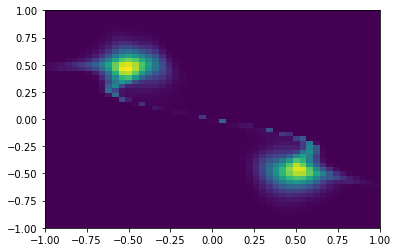

In [17]:
xo = 1.*obs_stats.flatten()

lims = np.array([[-1,1], [-1,1]])
i,j = 0,1
resolution = 50
        
xx = np.linspace(lims[i, 0], lims[i, 1], resolution)
yy = np.linspace(lims[j, 0], lims[j, 1], resolution)
X, Y = np.meshgrid(xx, yy)
xy = np.concatenate(
    [X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)
pp = model.eval((xo, xy), log=False).reshape(list(X.shape))

plt.imshow(pp.T, origin='lower',
           extent=[lims[j, 0], lims[j, 1], lims[i, 0], lims[i, 1]],
           aspect='auto', interpolation='none')
#plt.savefig('/home/mackelab/Desktop/SNL_5rounds_final_likelihood_tightll.pdf')
plt.show()

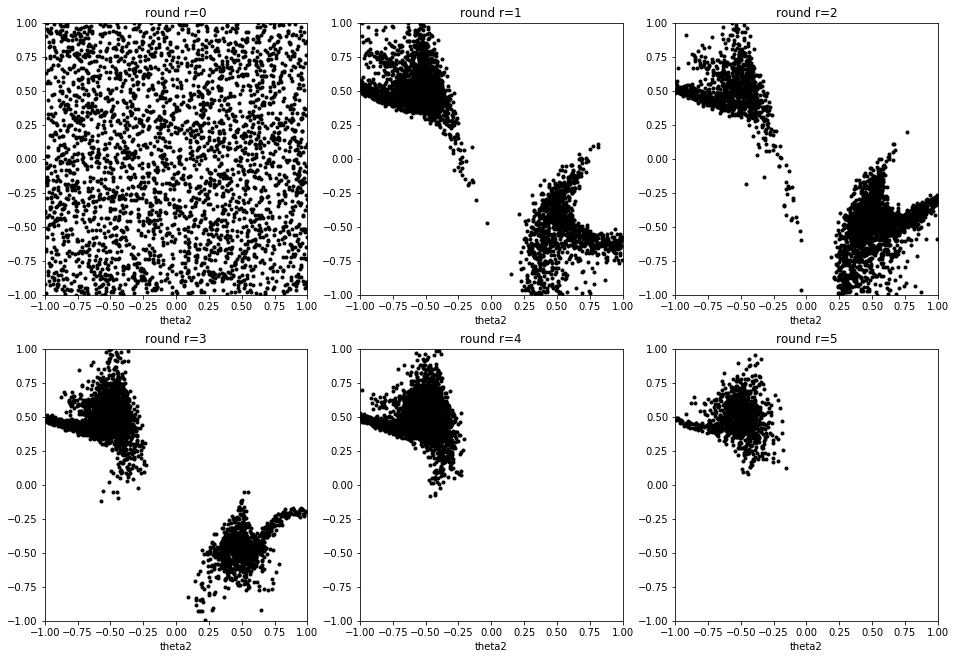

In [18]:
plt.figure(figsize=(16,11))
for r in range(n_rounds):
    plt.subplot(2,3,(r+1))
    plt.plot(inf.all_ps[r][:,0],
             inf.all_ps[r][:,1], 'k.')
    plt.axis([-1,1,-1,1])
    plt.xlabel('theta1')
    plt.xlabel('theta2')
    plt.title('round r='+str(r))

plt.subplot(2,3,6)
plt.plot(ps[:,0],
         ps[:,1], 'k.')
plt.axis([-1,1,-1,1])
plt.xlabel('theta1')
plt.xlabel('theta2')
plt.title('round r='+str(n_rounds))
#plt.savefig('/home/mackelab/Desktop/posteriors_per_round_tightll.pdf')
    
plt.show()

# SNPE A

In [19]:
g = init_g(seed=seed)

res_A = infer.CDELFI(g, 
                 obs=obs_stats, 
                 n_hiddens=n_hiddens, 
                 n_components=n_components,
                 seed=seed, 
                 reg_lambda=reg_lambda,
                 pilot_samples=pilot_samples,
                 svi=svi,
                 verbose=verbose,
                 init_norm=init_norm,
                 prior_norm=prior_norm)

t = timeit.time.time()

logs_A, tds_A, posteriors_A = res_A.run(n_train=n_train, 
                    n_rounds=n_rounds, 
                    minibatch=minibatch, 
                    epochs=epochs)

print(timeit.time.time() -  t)








analytic correction for proposal seemingly failed!
6.5898730754852295


# SNPE C

In [20]:
g = init_g(seed=seed)

n_null = 2 

res_C = infer.SNPEC(g, 
                 obs=obs_stats, 
                 n_hiddens=n_hiddens, 
                 n_components=n_components,
                 seed=seed, 
                 reg_lambda=reg_lambda,
                 pilot_samples=pilot_samples,
                 svi=svi,
                 verbose=verbose,
                 prior_norm=prior_norm)

t = timeit.time.time()

logs_C, tds_C, posteriors_C = res_C.run(n_train=n_train, 
                    proposal='discrete',
                    moo='resample',
                    n_null = n_null,
                    n_rounds=n_rounds, 
                    minibatch=minibatch, 
                    epochs=epochs)

print(timeit.time.time() -  t)












57.80021834373474


/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


AttributeError: 'NoneType' object has no attribute 'ndim'

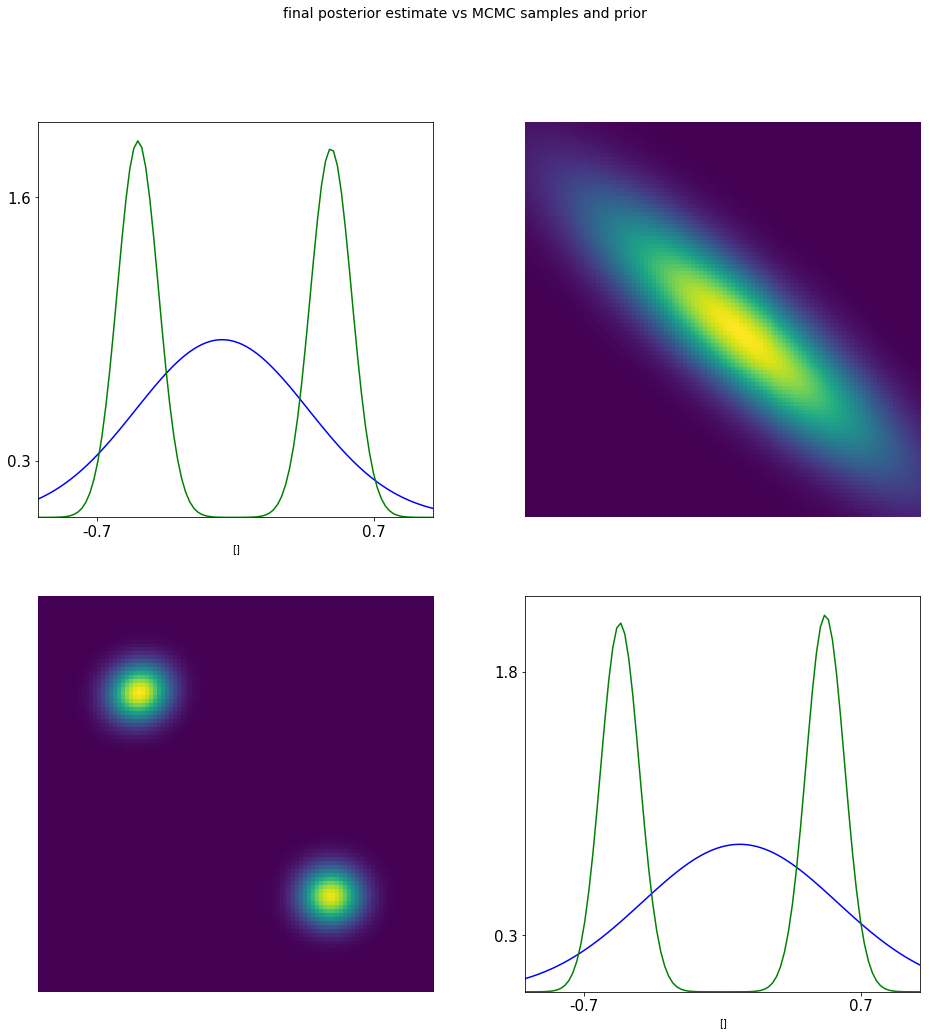

In [21]:
for r in range(n_rounds):
    fig,_ = plot_pdf(posteriors_A[r],
             pdf2=posteriors_C[r],
             lims=[[-1,1],[-1,1]],
             ticks=True,             
             #pdf2=g.prior,
             #gt=np.array([5,-5]), 
             resolution=100,
             figsize=(16,16));
    fig.suptitle('final posterior estimate vs MCMC samples and prior', fontsize=14)
    fig.show()
